In [1]:
import mitsuba as mi
mi.set_variant('cuda_ad_rgb')
import matplotlib.pyplot as plt
import os

from calibration.helpers.io import *
from calibration.helpers.camera_model import *
from calibration.helpers.linear_alg import *
from mitsuba import ScalarTransform4f as T

import drjit as dr

from ipywidgets import interact

# Paths

In [2]:
folder_dataset = '../datasets/'
folder_params = 'data'
dataset_name = 'unanno36_sorted256_theta_5_70_8_phi_0_360_16'
path_dataset = os.path.join(folder_dataset, dataset_name)
path_params = os.path.join(folder_params, 'npp_' + dataset_name + '.npy')

# Functions

In [3]:
def to_world(dataset, arr_angles, params):
  """ Get to world matrix for a given set of angles """
  # Filtering can be optimized
  arr_mtx = []

  for angles_inp in arr_angles:
    for i, entry in enumerate(dataset):
      angles, wo_measured, vargeo, pg_cam_matrix, ch_ids, ch_corners = entry[0] # No image required
      theta_i, phi_i, theta_o, phi_o = angles

      if theta_o == angles_inp[0] and \
         phi_o == angles_inp[1] and \
         vargeo == angles_inp[2]:

        mtx = get_to_world(params, pg_cam_matrix)
        mtx[:3, 3] *= 0.001
        arr_mtx.append(mtx)

  return np.array(arr_mtx)

In [4]:
def tfm_plane(params):
  ij_to_sample = rot_scipy(params[:3])
  ij_to_sample[0:3, 3] = params[3:6] * 0.001
  return T(ij_to_sample) @ T.translate([.31/2, .18/2, 0])

# Reconstructing from Captures

In [5]:
dataset = read_dataset(path_dataset, 64, v=True)
params_cam = load_params(path_params, v=True)

Reading ../datasets/unanno36_sorted256_theta_5_70_8_phi_0_360_16:   9%|▉         | 6/64 [00:01<00:17,  3.27it/s]

In [6]:
thetas_uniq, phis_uniq, vars_uniq = get_dataset_angles(dataset)
print("Available angles")
print(thetas_uniq, phis_uniq, vars_uniq)

Available angles
[ 5 14 23 32 42 51 60 70] [  0  22  45  67  90 112 135 157 180 202 225 247 270 292 315 337] [0 1]


In [7]:
arr_angles = np.array([
  [5, 0, 1],
  [51, 0, 0],
  [70, 337, 0],
  [70, 225, 1],
])

arr_to_worlds = to_world(dataset, arr_angles, params_cam)
mtx_plane = tfm_plane(params_cam)

# Optimization

In [8]:
def_sample_count = 128
def_res_x = 6576 // 2
def_res_y = 4384 // 2
path_tex_targ = 'scenes/textures/charuco.png'
path_tex_init = 'scenes/textures/init.png'

In [9]:
def make_sensors(arr_to_worlds, yfov, resx, resy, aspect=1.5, sample_count=128):
  sensors = []
  for i, mtx in enumerate(arr_to_worlds):
    sensor = mi.load_dict({
      'type': 'perspective',
      'fov_axis': 'x',
      'near_clip': 0.001,
      'far_clip': 1000,
      'fov': yfov * aspect,
      'to_world': T(mtx),
      'sampler': {
        'type': 'independent',
        'sample_count': sample_count,
      },
      'film': {
        'type': 'hdrfilm',
        'width': resx,
        'height': resy,
        'rfilter': {
          'type': 'tent',
        }
      }
    })
    sensors.append(sensor)

  return sensors

def make_scene(path_tex, arr_to_worlds, mtx_plane, params_cam, resx, resy, aspect=1.5, sample_count=128):
  sensors = make_sensors(arr_to_worlds, params_cam[6], 
                         resx, resy, aspect, sample_count)
  
  scene = mi.load_dict({
    'type': 'scene',
    'integrator': {
      'type': 'direct_reparam',
      'max_depth': 8,
    },

    # BSDFS
    'charuco': {
        'type': 'twosided',
        'material': {
            'type': 'diffuse',
            'reflectance': {
                'type': 'bitmap',
                'filename': path_tex,
                'filter_type': 'bilinear',
            }
        },
    },

    # Light
    'light': {
      'type': 'constant',
      'radiance': {
        'type': 'rgb',
        'value': 1.0,
      }
    },

    # Shapes
    'tex_plane': {
      'type': 'obj',
      'filename': 'scenes/meshes/tex_plane.obj',
      'to_world': T(mtx_plane) @ T.rotate(axis=[0,1,0], angle=-90),
      'bsdf': {
        'type': 'ref',
        'id': 'charuco',
      },
    },

    'sample_holder': {
      'type': 'obj',
      'filename': 'scenes/meshes/holder.obj',
      'to_world': T.translate([0, 0, 0.004]) @ T(mtx_plane) @ T.rotate(axis=[1,0,0], angle=-90),
    }      
  })

  return scene, sensors

In [10]:
scene_opt, sensors = make_scene(path_tex_init, arr_to_worlds, mtx_plane, params_cam, 
                            def_res_x, def_res_y,
                            aspect=1.5, sample_count=def_sample_count)

In [11]:
## Read Images
ref_imgs = []
ref_img_0 = mi.TensorXf(mi.Bitmap('./captures/0_0_5_0_1.png').convert(mi.Bitmap.PixelFormat.RGB, mi.Struct.Type.Float32).resample([def_res_x, def_res_y]))
ref_img_1 = mi.TensorXf(mi.Bitmap('./captures/0_0_51_0_0.png').convert(mi.Bitmap.PixelFormat.RGB, mi.Struct.Type.Float32).resample([def_res_x, def_res_y]))
ref_img_2 = mi.TensorXf(mi.Bitmap('./captures/0_0_70_337_0.png').convert(mi.Bitmap.PixelFormat.RGB, mi.Struct.Type.Float32).resample([def_res_x, def_res_y]))
ref_img_3 = mi.TensorXf(mi.Bitmap('./captures/0_0_70_225_1.png').convert(mi.Bitmap.PixelFormat.RGB, mi.Struct.Type.Float32).resample([def_res_x, def_res_y]))

ref_imgs.append(ref_img_0)
ref_imgs.append(ref_img_1)
ref_imgs.append(ref_img_2)
ref_imgs.append(ref_img_3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


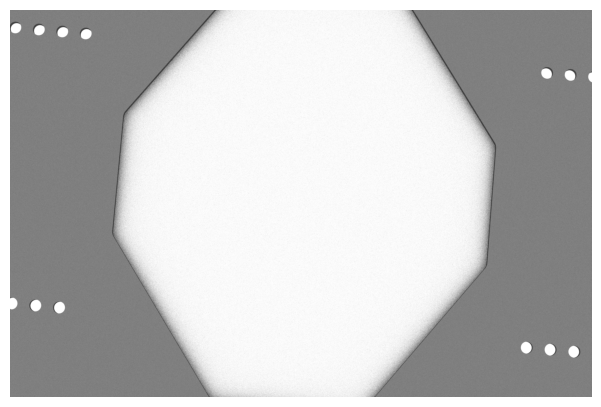

In [12]:
img_test = mi.render(scene_opt, sensor=sensors[0], spp=16)

plt.figure(figsize=(7.5,7.5))
plt.axis('off')
plt.imshow(img_test);

In [13]:
params = mi.traverse(scene_opt)
param_key = 'charuco.brdf_0.reflectance.data'
opt = mi.ad.Adam(lr=0.1)
opt[param_key] = params[param_key]
opt['sh_translation'] = mi.Vector2f(0, 0)
opt.set_learning_rate({'sh_translation': 1e-5, 'charuco.brdf_0.reflectance.data': 1e-1})
params.update(opt);

In [14]:
initial_vertex_pos = dr.unravel(mi.Point3f, params['sample_holder.vertex_positions'])

def update_vertex_pos():
    # Create the translation transformation
    v = mi.Vector3f(opt['sh_translation'].x, opt['sh_translation'].y, 0)
    T = mi.Transform4f.translate(v)

    # Apply the transformation to the vertex positions
    new_vertex_pos = T @ initial_vertex_pos

    # Flatten the vertex position array before assigning it to `params`
    params['sample_holder.vertex_positions'] = dr.ravel(new_vertex_pos)

    # Propagate changes through the scene (e.g. rebuild BVH)
    params.update()

In [15]:
iteration_count = 50
errors = []
sensor_count = len(sensors)

for it in range(iteration_count):
  total_loss = 0
  for sensor_idx in range(sensor_count):
    img = mi.render(scene_opt, params, sensor=sensors[sensor_idx], spp=1, seed=it)

    loss = dr.mean(dr.sqr(img - ref_imgs[sensor_idx]))

    dr.backward(loss)

    opt.step()
    # update_vertex_pos()
    
    opt[param_key] = dr.clamp(opt[param_key], 0.0, 1.0)

    params.update(opt)

    total_loss += loss

  print(f"Iteration {it:02d}: error={total_loss[0]:6f}", end='\r')
  errors.append(total_loss)


2022-11-22 11:09:06 WARN main [common.py:390] sample_rays(): ADIntegrator detected the potential for image-space motion due to differentiable shape or camera pose parameters. To correctly account for shapes entering or leaving the viewport, it is recommended that you set the film's 'sample_border' parameter to True.

2022-11-22 11:09:08 WARN main [common.py:390] sample_rays(): ADIntegrator detected the potential for image-space motion due to differentiable shape or camera pose parameters. To correctly account for shapes entering or leaving the viewport, it is recommended that you set the film's 'sample_border' parameter to True.

2022-11-22 11:09:10 WARN main [common.py:390] sample_rays(): ADIntegrator detected the potential for image-space motion due to differentiable shape or camera pose parameters. To correctly account for shapes entering or leaving the viewport, it is recommended that you set the film's 'sample_border' parameter to True.

2022-11-22 11:09:11 WARN main [common.py:390] sample_rays(): ADIntegrator detected the potential for image-space motion due to differentiable shape or camera pose parameters. To correctly account for shapes entering or leaving the viewport, it is recommended that you set the film's 'sample_border' parameter to True.

2022-11-22 11:09:12 WARN main [common.py:390] sample_rays(): ADIntegrator detected the potential for image-space motion due to differentiable shape or camera pose parameters. To correctly account for shapes entering or leaving the viewport, it is recommended that you set the film's 'sample_border' parameter to True.

2022-11-22 11:09:13 WARN main [common.py:390] sample_rays(): ADIntegrator detected the potential for image-space motion due to differentiable shape or camera pose parameters. To correctly account for shapes entering or leaving the viewport, it is recommended that you set the film's 'sample_border' parameter to True.

2022-11-22 11:09:14 WARN main [common.py:390] sample_rays(): ADIntegrator detected the potential for image-space motion due to differentiable shape or camera pose parameters. To correctly account for shapes entering or leaving the viewport, it is recommended that you set the film's 'sample_border' parameter to True.

2022-11-22 11:09:15 WARN main [common.py:390] sample_rays(): ADIntegrator detected the potential for image-space motion due to differentiable shape or camera pose parameters. To correctly account for shapes entering or leaving the viewport, it is recommended that you set the film's 'sample_border' parameter to True.

2022-11-22 11:09:16 WARN main [common.py:390] sample_rays(): ADIntegrator detected the potential for image-space motion due to differentiable shape or camera pose parameters. To correctly account for shapes entering or leaving the viewport, it is recommended that you set the film's 'sample_border' parameter to True.

In [16]:
img_opt = mi.render(scene_opt, sensor=sensors[3], spp=16, seed=it)
mi.util.write_bitmap(f'final_image.png', img_opt, write_async=True)

In [17]:
for i in range(len(sensors)):
  img_opt = mi.render(scene_opt, sensor=sensors[i], spp=16, seed=it)
  mi.util.write_bitmap(f'final_image_{i}.png', img_opt, write_async=True)

In [18]:
for i in range(len(sensors)):
  mi.util.write_bitmap(f'ref_image_{i}.png', ref_imgs[i], write_async=True)

In [19]:
params_ref_bm = mi.util.convert_to_bitmap(params[param_key]).convert(mi.Bitmap.PixelFormat.RGB,
                                                              mi.Struct.Type.UInt8, False)

In [20]:
mi.util.write_bitmap(f'recon_tex.png', params_ref_bm, write_async=True)

# Scratch

In [117]:
v = mi.Vector2f(1,2)
v2 = mi.Vector3f(v.x, v.y, 0)
mi.Transform4f.translate(v2)

[[[1, 0, 0, 1],
  [0, 1, 0, 2],
  [0, 0, 1, 0],
  [0, 0, 0, 1]]]